<center><h1>DSCI-552 Final Project<h1></center>

# Name:Tao Yang  Github Username: utopiatao  USCID:6536418689

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import splitfolders
import random
import shutil
import cv2
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from torch.optim import Adam
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow import keras
from keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")


## 1. Transfer Learning for Image Classification1
It is highly recommended that you complete this project using Keras2 and Python.


#### (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.


#### (b) Data Exploration and Pre-processing

i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore,
you encode your classes using one-hot encoding and Classes.xlsx.

In [2]:
class_dict = pd.read_excel("../data/Classes.xlsx",index_col = None)

In [3]:
class_dict

,Folder Name,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


In order for all the images to have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.

In [4]:
for idx,data in class_dict.iterrows():
    directory = '../Data/images/'+data[0]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        image = cv2.imread(f)
        down_width = 300
        down_height = 200
        down_points = (down_width, down_height)
        resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
        cv2.imwrite(f, resized_down)

Randomly select d0.7nie images from each folder as your training set, d0.15nie
as validation set, and the rest as your test set, where ni
is the number of
images in folder i and dxe is the ceiling of x.

In [5]:
inputfolder = '../Data/images'
splited = splitfolders.ratio(inputfolder, output = "output", seed = 1, ratio = (0.7, 0.15, 0.15))

Copying files: 1176 files [00:08, 141.77 files/s]


### (c) Transfer Learning3

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train
them. In such cases, one usually uses transfer learning, which uses deep
learning models that are trained on very large datasets such as ImageNet
as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and
the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given
that we have 20 classes, training a deep network with such a small dataset
may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e.
we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.

ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast,
and translate images in your training set for image augmentation. You can
use various tools to do this, including OpenCV.

In [6]:
for idx,data in class_dict.iterrows():
    directory = '../notebook/output/train/'+data[0]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        image = cv2.imread(f)
        random_width = random.randint(2,12) * 100
        random_height = random.randint(2,12) * 100
        points = (random_width, random_height)
        resized = cv2.resize(image, points, interpolation= cv2.INTER_LINEAR)
        if_flip = random.randint(0,3)
        if if_flip == 1:
            resized = cv2.flip(resized, 0)
        elif if_flip == 2:
            resized = cv2.flip(resized, 1)
        elif if_flip == 3:
            resized = cv2.flip(resized, 0)
            resized = cv2.flip(resized, 1)
        cv2.imwrite(f, resized)

iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable.


In [7]:
#3
train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)

In [8]:
#3
train_dataset = train.flow_from_directory('../notebook/output/train/',
                                          target_size=(200, 200),
                                         batch_size = 5,
                                          class_mode='categorical')

Found 820 images belonging to 20 classes.


In [9]:
#3
validation_dataset = train.flow_from_directory('../notebook/output/val/',
                                                target_size=(200, 200),
                                         batch_size = 5,
                                          class_mode='categorical')

Found 171 images belonging to 20 classes.


In [10]:
train_dataset.class_indices

{'005.Crested_Auklet': 0,
 '013.Bobolink': 1,
 '015.Lazuli_Bunting': 2,
 '023.Brandt_Cormorant': 3,
 '040.Olive_sided_Flycatcher': 4,
 '041.Scissor_tailed_Flycatcher': 5,
 '067.Anna_Hummingbird': 6,
 '072.Pomarine_Jaeger': 7,
 '076.Dark_eyed_Junco': 8,
 '081.Pied_Kingfisher': 9,
 '082.Ringed_Kingfisher': 10,
 '086.Pacific_Loon': 11,
 '099.Ovenbird': 12,
 '104.American_Pipit': 13,
 '127.Savannah_Sparrow': 14,
 '135.Bank_Swallow': 15,
 '141.Artic_Tern': 16,
 '149.Brown_Thrasher': 17,
 '156.White_eyed_Vireo': 18,
 '168.Kentucky_Warbler': 19}

In [11]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (200, 200, 3)),
                                    tf.keras.layers.BatchNormalization(momentum=0.2),
                                   #
                                    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
                                    tf.keras.layers.BatchNormalization(momentum=0.2),
                                    #
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.BatchNormalization(momentum=0.2),
                                    ##
                                    tf.keras.layers.Flatten(),
                                    ##
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    ##
                                    tf.keras.layers.Dense(20, activation = 'softmax')
])

iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs
(preferably 100 epochs) and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs.

In [12]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(lr = 0.001),
             metrics = ['accuracy'])

In [47]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [48]:
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [49]:
model_fit = model.fit_generator(train_dataset,
                     steps_per_epoch = 10,
                     epochs = 100,
                      validation_data = validation_dataset,
                    callbacks=[checkpoint, early]
                     )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 19.3698 - accuracy: 0.6000
Epoch 1: val_loss improved from inf to 1297.35498, saving model to vgg16_1.h5
10/10 [==============================] - 168s 18s/step - loss: 19.3698 - accuracy: 0.6000 - val_loss: 1297.3550 - val_accuracy: 0.1111
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 5.1766 - accuracy: 0.7200
Epoch 2: val_loss improved from 1297.35498 to 446.43851, saving model to vgg16_1.h5
10/10 [==============================] - 151s 16s/step - loss: 5.1766 - accuracy: 0.7200 - val_loss: 446.4385 - val_accuracy: 0.0760
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 3.1512 - accuracy: 0.6800
Epoch 3: val_loss improved from 446.43851 to 315.99142, saving model to vgg16_1.h5
10/10 [==============================] - 153s 17s/step - loss: 3.1512 - accuracy: 0.6800 - val_loss: 315.9914 - val_accuracy: 0.0877
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - 45s 5s/step - loss: 5.8423 - accuracy: 0.5800 - val_loss: 450.7281 - val_accuracy: 0.0877
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 5.7474 - accuracy: 0.7400
Epoch 30: val_loss did not improve from 128.54491
10/10 [==============================] - 44s 5s/step - loss: 5.7474 - accuracy: 0.7400 - val_loss: 426.3539 - val_accuracy: 0.0585
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 11.6731 - accuracy: 0.6400
Epoch 31: val_loss improved from 128.54491 to 121.76817, saving model to vgg16_1.h5
10/10 [==============================] - 157s 17s/step - loss: 11.6731 - accuracy: 0.6400 - val_loss: 121.7682 - val_accuracy: 0.0351
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 2.9476 - accuracy: 0.5600
Epoch 32: val_loss did not improve from 121.76817
10/10 [==============================] - 47s 5s/step - loss: 2.9476 - accuracy: 0.5600 - val_loss: 476.3105 - val_accuracy: 0.0994


Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.7400
Epoch 59: val_loss did not improve from 91.93818
10/10 [==============================] - 45s 5s/step - loss: 1.0473 - accuracy: 0.7400 - val_loss: 754.0551 - val_accuracy: 0.1111
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 1.8378 - accuracy: 0.7400
Epoch 60: val_loss did not improve from 91.93818
10/10 [==============================] - 45s 5s/step - loss: 1.8378 - accuracy: 0.7400 - val_loss: 163.9984 - val_accuracy: 0.0702
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.7800
Epoch 61: val_loss did not improve from 91.93818
10/10 [==============================] - 45s 5s/step - loss: 0.7561 - accuracy: 0.7800 - val_loss: 264.7824 - val_accuracy: 0.0643
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.6600
Epoch 62: val_loss did not improve from 91.93818
10/10 [====================

In [58]:
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']

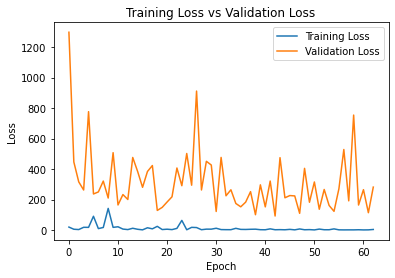

In [59]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

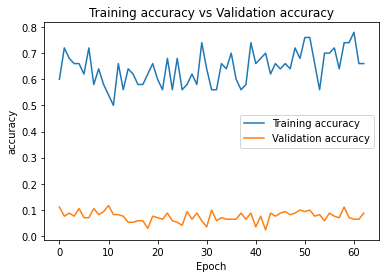

In [60]:
plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

v. Report Precision, Recall, and F1 score for your model. Remember that this
is a multi-class classification problem.

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [51]:
validation_generator = test_datagen.flow_from_directory('../notebook/output/test/',
                                          target_size=(200, 200),
                                         batch_size = 5,
                                                        class_mode='categorical')

Found 185 images belonging to 20 classes.


In [52]:
Y_pred = model.predict_generator(validation_generator, 185 // 5+1)

In [53]:
y_pred = np.argmax(Y_pred, axis=1)

In [54]:
print(confusion_matrix(validation_generator.classes, y_pred))

[[0 0 0 1 1 0 0 0 0 1 1 3 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 1 0 0 5 0 0 0 0 0 1 0 0]
 [0 1 1 0 1 1 0 0 0 0 2 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 5 0 1 0 0 0 0 1 0]
 [0 2 0 0 0 0 0 0 1 1 1 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 1 0 0 4 0 0 2 0 0 0 0 0]
 [0 2 0 1 0 0 0 0 0 0 0 5 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 3 1 0 2 0 0 0 1 0]
 [0 0 0 0 0 1 0 1 0 0 1 3 1 1 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 2 4 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0 1 5 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 2 0 2 0 1 0 1 1 0]
 [0 1 1 0 0 0 0 2 0 1 0 3 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 2 2 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 2 5 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 7 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 1 0 0 0 0 0 7 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 5 0 2 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 2 0 4 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 1 0 3 0 4 0 0 0 0 0 0 0 0]]


In [55]:
target_names = []
for i in range(1, 21):
    target_names.append('Class ' + str(i))


In [56]:
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00         8
     Class 2       0.00      0.00      0.00         9
     Class 3       0.50      0.10      0.17        10
     Class 4       0.00      0.00      0.00        10
     Class 5       0.00      0.00      0.00         9
     Class 6       0.12      0.11      0.12         9
     Class 7       0.00      0.00      0.00         9
     Class 8       0.00      0.00      0.00         9
     Class 9       0.00      0.00      0.00         9
    Class 10       0.00      0.00      0.00         9
    Class 11       0.07      0.11      0.08         9
    Class 12       0.02      0.22      0.04         9
    Class 13       0.00      0.00      0.00         9
    Class 14       0.00      0.00      0.00         9
    Class 15       0.00      0.00      0.00         9
    Class 16       0.00      0.00      0.00        10
    Class 17       0.00      0.00      0.00        10
    Class 18       0.12    